In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

c:\Users\tunga\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = Path("Sugarcane Dataset")

Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 5 directories and 0 images in 'Sugarcane Dataset'.
There are 0 directories and 522 images in 'Sugarcane Dataset\Healthy'.
There are 0 directories and 462 images in 'Sugarcane Dataset\Mosaic'.
There are 0 directories and 518 images in 'Sugarcane Dataset\RedRot'.
There are 0 directories and 514 images in 'Sugarcane Dataset\Rust'.
There are 0 directories and 505 images in 'Sugarcane Dataset\Yellow'.


Random Image Path: Sugarcane Dataset\RedRot\redrot (341).jpeg
Image Class: RedRot
Image Height: 585
Image Width: 1040


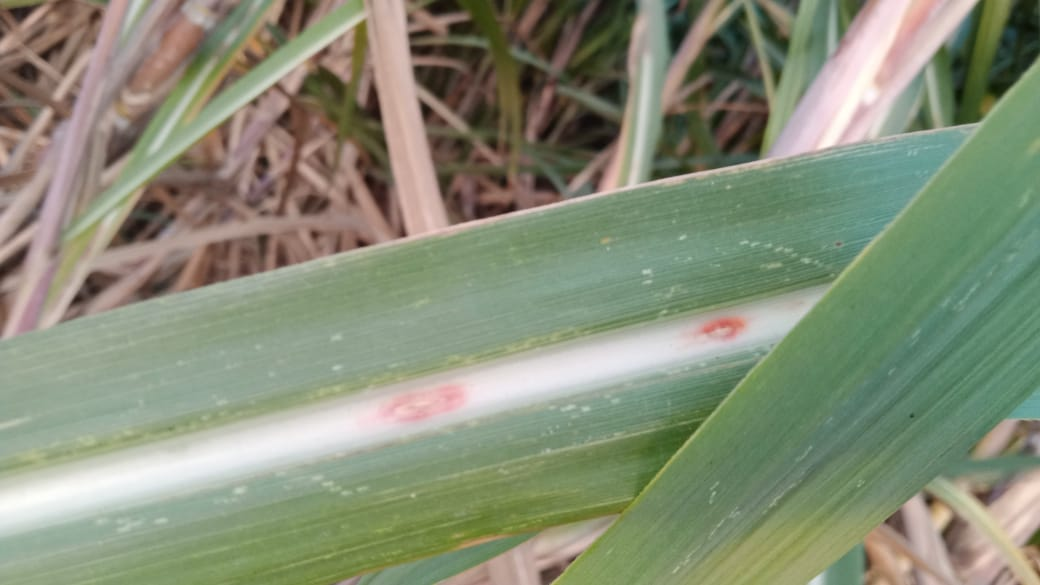

In [3]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*.jpeg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 1039.5, 584.5, -0.5)

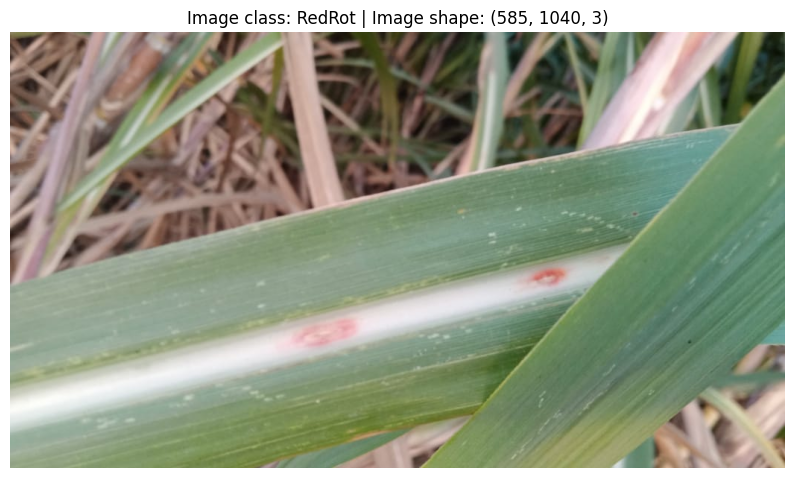

In [4]:
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

In [5]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

custom_dataset = datasets.ImageFolder(root=image_path, transform=transform)
loader = torch.utils.data.DataLoader(custom_dataset, batch_size=32, shuffle=False, num_workers=2)

mean = 0.0
std = 0.0
total_images_count = 0

for images, _ in loader:
    batch_images_count = images.size(0)
    images = images.view(batch_images_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_images_count

mean /= total_images_count
std /= total_images_count

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.4977, 0.5281, 0.3800])
Std: tensor([0.1744, 0.1733, 0.1814])


Transforming Data


In [6]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std) 
])
img_path = Image.open('Sugarcane Dataset\Mosaic\mosaic (6).jpeg')
transformed_image = transforms(img_path)
transformed_image

Image([[[-1.8198, -1.7299, -1.5949,  ...,  0.0470,  0.0245,  0.1145],
        [-1.8648, -1.7074, -1.5274,  ...,  0.0695,  0.0245,  0.0920],
        [-1.8648, -1.6849, -1.4600,  ...,  0.0695,  0.0245,  0.0245],
        ...,
        [-0.2004, -0.4253, -0.7177,  ..., -0.8527, -0.8077, -0.7852],
        [-0.2679, -0.5378, -0.8977,  ..., -0.8527, -0.7852, -0.7627],
        [-0.3803, -0.6727, -1.0551,  ..., -0.8077, -0.7852, -0.7402]],

       [[-2.3228, -2.2549, -2.1418,  ..., -0.7617, -0.7391, -0.6938],
        [-2.3454, -2.2323, -2.0739,  ..., -0.7164, -0.7391, -0.6938],
        [-2.3454, -2.2097, -2.0061,  ..., -0.6938, -0.7164, -0.7391],
        ...,
        [-1.1237, -1.3047, -1.4631,  ..., -1.3047, -1.1011, -0.9879],
        [-1.1916, -1.3952, -1.5988,  ..., -1.2821, -1.0784, -0.9653],
        [-1.2594, -1.4857, -1.7119,  ..., -1.2142, -1.0558, -0.9427]],

       [[-1.6190, -1.5974, -1.5110,  ..., -0.4732, -0.4732, -0.4300],
        [-1.6407, -1.5758, -1.4461,  ..., -0.4084, -0.4732, 

In [7]:
transforms(img).shape

torch.Size([3, 224, 224])

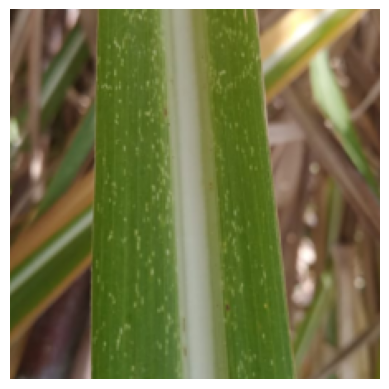

In [8]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
transformed_image = denormalize(transformed_image, mean, std)
transformed_image = transformed_image.numpy().transpose((1, 2, 0))
plt.imshow(transformed_image)
plt.axis('off')
plt.show()


In [9]:
dataset = datasets.ImageFolder(root=image_path, transform = transforms)
train_ratio = 0.8
test_ratio = 0.2
classes = dataset.classes
classes

['Healthy', 'Mosaic', 'RedRot', 'Rust', 'Yellow']

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
targets = [label for _, label in dataset.samples]

# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Create stratified split
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, train_size=train_ratio)

# Get train and test indices
train_indices, test_indices = next(strat_split.split(np.zeros(len(targets)), targets))

# Create train and test subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the number of samples in each set
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

# Verify the class distribution in each set
train_targets = [targets[i] for i in train_indices]
test_targets = [targets[i] for i in test_indices]

print(f'Training set class distribution: {np.bincount(train_targets)}')
print(f'Testing set class distribution: {np.bincount(test_targets)}')

Number of training samples: 2016
Number of testing samples: 505
Training set class distribution: [417 370 414 411 404]
Testing set class distribution: [105  92 104 103 101]


In [11]:
class_dict = dataset.class_to_idx
class_dict

{'Healthy': 0, 'Mosaic': 1, 'RedRot': 2, 'Rust': 3, 'Yellow': 4}

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*53*53,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

In [14]:
from torchvision import datasets, transforms, models
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
# import torch.optim as optim

# # Define your network, criterion, optimizer, and data loader (trainloader) here

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device)

# for epoch in range(30):  # loop over the dataset multiple times

#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # accumulate loss
#         running_loss += loss.item()

#         # calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # print statistics every 2000 mini-batches
#         if i % 2000 == 1999:
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

#     # print loss and accuracy for each epoch
#     accuracy = 100 * correct / total
#     print(f'Epoch {epoch + 1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {accuracy:.2f}%')

# print('Finished Training')


In [15]:
best_accuracy = 0
patience = 5  # Early stopping patience
patience_counter = 0

for epoch in range(30):  # Train for 30 epochs
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Update learning rate
    accuracy = 100 * correct / total
    print(f'Epoch {epoch + 1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {accuracy:.2f}%')

    # Validation
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

print('Finished Training')


Epoch 1 - Loss: 1.619, Accuracy: 29.12%
Test Accuracy: 48.91%
Epoch 2 - Loss: 1.276, Accuracy: 45.34%
Test Accuracy: 52.48%
Epoch 3 - Loss: 1.144, Accuracy: 54.22%
Test Accuracy: 62.97%
Epoch 4 - Loss: 0.950, Accuracy: 62.65%
Test Accuracy: 62.77%
Epoch 5 - Loss: 0.891, Accuracy: 65.67%
Test Accuracy: 65.94%
Epoch 6 - Loss: 0.833, Accuracy: 68.01%
Test Accuracy: 73.47%
Epoch 7 - Loss: 0.774, Accuracy: 70.54%
Test Accuracy: 72.87%
Epoch 8 - Loss: 0.654, Accuracy: 74.90%
Test Accuracy: 76.44%
Epoch 9 - Loss: 0.631, Accuracy: 75.35%
Test Accuracy: 76.63%
Epoch 10 - Loss: 0.613, Accuracy: 76.79%
Test Accuracy: 76.63%
Epoch 11 - Loss: 0.594, Accuracy: 77.83%
Test Accuracy: 77.62%
Epoch 12 - Loss: 0.583, Accuracy: 77.53%
Test Accuracy: 77.62%
Epoch 13 - Loss: 0.570, Accuracy: 79.07%
Test Accuracy: 75.64%
Epoch 14 - Loss: 0.582, Accuracy: 77.98%
Test Accuracy: 78.02%
Epoch 15 - Loss: 0.545, Accuracy: 79.71%
Test Accuracy: 78.02%
Epoch 16 - Loss: 0.535, Accuracy: 79.71%
Test Accuracy: 77.23%
E

In [17]:
PATH = './Model.pth'
torch.save(model.state_dict(), PATH)

In [16]:
correct = 0
total = 0

model.eval() 
with torch.no_grad(): 
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


Test Accuracy: 77.23%


In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 76 %


In [20]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Healthy is 81.0 %
Accuracy for class: Mosaic is 66.3 %
Accuracy for class: RedRot is 75.0 %
Accuracy for class: Rust  is 76.7 %
Accuracy for class: Yellow is 79.2 %
